# 3.1 Optimisation and training

So far, we have seen how to define a neural network, how to train it and how to test it. However, we have not really discussed how to train it _properly_: What can we do to avoid under- and overfitting? When should we stop the training loop?

<!--
- [Early stopping](#Early-stopping)
- [Hyper parameter tuning](#Hyper-parameter-tuning)
- [Exercises](#Exercises)
-->

To decrease the training time, we settle for a simple CNN architecture and use the MNIST data set that you explored in notebook 1.2.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Check if a GPU is available and set the device (cf. notebook 2.2)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define a simple CNN architecture
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(16 * 14 * 14, 10)  # 10 classes for MNIST

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Load the MNIST dataset for training
mnist_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)

# Define the size of your validation set
validation_set_size = int(0.2 * len(mnist_dataset))  # Adjust the percentage as needed

# Split the dataset into training and validation sets
train_dataset, validation_dataset = random_split(mnist_dataset, [len(mnist_dataset) - validation_set_size, validation_set_size])

# Create DataLoader for training and validation sets
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=64, shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## Early stopping

Rather than fixing the number of epochs that we train the model for, we trigger the training to stop early if no improvement in the validation loss is achieved within a number of consecutive epochs. We use the term patience to describe the number of epochs during which the network waits for an improvement of the validation loss.

In [2]:
# Function to train the model
def train_model(model, train_loader, criterion, optimizer, num_epochs, patience):
    model.to(device)
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation loss
        model.eval()
        with torch.no_grad():
            val_loss = 0.0
            for inputs, labels in validation_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

            avg_val_loss = val_loss / len(validation_loader)
            val_losses.append(avg_val_loss)

            # Early stopping
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f'Early stopping at epoch {epoch + 1} due to no improvement in validation loss.')
                    break

        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

    return train_losses, val_losses

Epoch [1/20], Train Loss: 0.2915, Val Loss: 0.1437
Epoch [2/20], Train Loss: 0.1015, Val Loss: 0.0887
Epoch [3/20], Train Loss: 0.0732, Val Loss: 0.0824
Epoch [4/20], Train Loss: 0.0592, Val Loss: 0.0701
Epoch [5/20], Train Loss: 0.0493, Val Loss: 0.0746
Epoch [6/20], Train Loss: 0.0438, Val Loss: 0.0725
Early stopping at epoch 7 due to no improvement in validation loss.


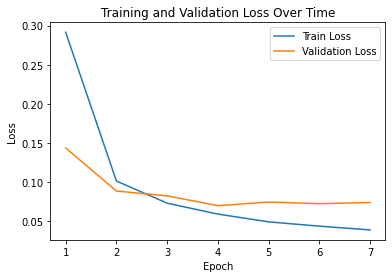

In [3]:
# Instantiate the model, loss function, and optimizer
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model with early stopping on the GPU
num_epochs = 20 # Maximum
patience = 3
train_losses, val_losses = train_model(model, train_loader, criterion, optimizer, num_epochs, patience)

# Plot the training and validation loss
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Over Time')
plt.show()

## Hyper-parameter tuning

Until now, we have set different hyper-parameters, like the learning rate, manually. But how did we choose this value? Could we have done better? Indeed, we could. We could have optimised the hyper-parameter. In a nutshell, we can repeat the analysis with different values for the hyper-parameters and choose the hyper-parameter combination that works best. For a neural network, we might be interested in tuning the learning rate and changing a network layer size, i.e., adapting aspects of the architecture (see [here](https://pytorch.org/tutorials/beginner/hyperparameter_tuning_tutorial.html)). 

Of course, training a neural network many times to optimise the hyper-parameters takes time. To keep things simple and start out with some code that runs quickly to get a better feeling of the basic concepts of hyper-parameter tuning, let's start out with a simpler model. As discussed in notebook 1.3, you can also use PyTorch for linear fits, and these models train fast.

If you want to perform scalable hyper-parameter tuning, [RayTune](https://docs.ray.io/en/latest/tune/index.html) is a popular option for Deep Learning. Moreover, you can use grid search cross-validation and similar algorithms, e.g., from [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). To get a better understanding of what happens, however, let's write parts of one of these algorithms ourselves.

In [4]:
from torch.utils.data import TensorDataset
from sklearn.model_selection import KFold
import numpy as np

# PyTorch Linear Regression Model
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(1, 1)

    def forward(self, x):
        return self.linear(x)

# Generate synthetic data
torch.manual_seed(42)
X = 5 * torch.randn(100, 1)
y = 2 * X + 1 + 1.5 * torch.randn(100, 1)

# Convert data to NumPy arrays
X_np, y_np = X.numpy(), y.numpy()

# Convert data to PyTorch tensors
X_tensor, y_tensor = torch.tensor(X_np, dtype=torch.float32), torch.tensor(y_np, dtype=torch.float32)

# Number of epochs (you can experiment with this)
num_epochs = 25

# Initialize the linear regression model
model1 = LinearRegressionModel()

# Loss function
criterion = nn.MSELoss()

Here, we just want to optimise a single hyper-parameter, the learning rate. If you were to optimise several hyper-parameters, you would have to do so _in tandem_, i.e., you _cannot_ optimise one hyper-parameter and then keep it fixed and then optimise another hyper-parameter. Instead, you have to do all of them at the same time.

In [5]:
# Hyper-parameter search space (learning rates to try)
learning_rates = [1e-4, 1e-3, 1e-2]

To make better use of the data set, we split it into $k=5$ folds. We then repeat the training for each hyper-parameter value $k=5$ times, using $k-1=4$ folds for training, while we withhold the last fold for validation. This approach helps assess model performance on various subsets of the data, mitigating the impact of a specific split and thereby reducing the risk of overfitting to a single training-validation split. You can find a detailed explanation of k-fold cross-validation on [scikit-learn's homepage](https://scikit-learn.org/stable/modules/cross_validation.html), where you will find the following illustration of the concept.

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png">

For each iteration of the cross-validation, we need to define folds and learning rates before training. Hence, the training loop is wrapped in two other loops defining the learning rate and the training/validation data sets. 

In [6]:
# Number of folds for cross-validation
num_folds = 5

# Perform k-fold cross-validation
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

best_lr = None
best_loss = float('inf')

# Now we lopp over the learning rates.
for lr in learning_rates:
    # Initialize the model for each learning rate
    model1 = LinearRegressionModel()
    
    # We reset the learning rate in the optimiser
    optimizer = torch.optim.SGD(model1.parameters(), lr=lr)

    all_val_losses = []
    # Training loop with cross-validation
    for train_indices, val_indices in kf.split(X_np):
        # For each iteration of the loop, we define a training set based on 4 folds
        X_train, y_train = X_np[train_indices], y_np[train_indices]
        # And create a validation set based on the remaining fold
        X_val, y_val = X_np[val_indices], y_np[val_indices]

        # Since our data are numpy arrays, we need to turn them into tensors.
        train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                                      torch.tensor(y_train, dtype=torch.float32))
        val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32),
                                    torch.tensor(y_val, dtype=torch.float32))

        train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

        # Now we are ready for training
        for epoch in range(num_epochs):
            model1.train()
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = model1(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

        # We go through the batches in the validation set
        val_losses = []
        for inputs, labels in val_loader:
            model1.eval()
            with torch.no_grad():
                val_loss = criterion(model1(inputs), labels)
            val_losses.append(val_loss.item())

        # Average validation loss for the current fold
        avg_val_loss_fold = sum(val_losses) / len(val_losses)
        all_val_losses.append(avg_val_loss_fold)

    # Average validation loss for present lr
    avg_val_loss = sum(all_val_losses) / len(all_val_losses)

    # Update the best learning rate if necessary
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        best_lr = lr

# Print the best learning rate
print("Best Learning Rate:", best_lr)

Best Learning Rate: 0.01


Now, you have found the best value for the learning rate. But you are not done yet. While you have trained a model using the best learning rate, you trained this model using cross-validation, i.e., the model didn't see the whole data set during training.... So, you should retrain the model.

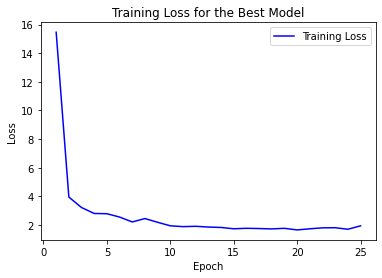

In [7]:
from sklearn.model_selection import train_test_split

# We first need to load the whole dataset
# Since we are not tuning anything we do not need to set data aside for validation.
# Rather, we want to fully exploit the dataset.

# Since our data are numpy arrays, we need to turn them into tensors.
train_dataset = TensorDataset(torch.tensor(X_np, dtype=torch.float32),
                              torch.tensor(y_np, dtype=torch.float32))

# We provide the data to the dataloader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Train the model with the best learning rate on the full training set
best_model = LinearRegressionModel()
best_optimizer = torch.optim.SGD(best_model.parameters(), lr=best_lr)

best_train_losses = []

for epoch in range(num_epochs):
    best_model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        best_optimizer.zero_grad()
        outputs = best_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        best_optimizer.step()
        running_loss += loss.item()

    # Training loss
    best_train_loss = running_loss / len(train_loader)
    best_train_losses.append(best_train_loss)

# Plot training and validation losses for the best model
plt.plot(range(1, num_epochs + 1), best_train_losses, label='Training Loss', color='b')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss for the Best Model')
plt.legend()
plt.show()

**Question to plot**: Why is the validation loss much smoother than the training loss?

**Hint**: Are we actually plotting the same thing? How many batches are used to compute the plotted training loss and how many to compute the plotted validation loss?

## Testing

When training machine-learning methods, it is essential to withhold data that can subsequently be used for testing. Before we can trust the predictions that the network makes for unlabelled data, we need to see how it performs for yet unseen labelled data. We thus want to check for signs of overfitting. Does the model generalise well? That's why we used randomsplit to create our validation set.

The first important step of testing is to ensure that the test data is preprocessed in the same manner as the training set. We could now test the performance of the model, e.g., by computing the accuracy on the test set. You saw this in notebook 2.1. But accuracy might not be a good choice. We will discuss this in Exercises 4-6.

In [8]:
# Load testset
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

## Exercises


**Exercise 1**: Discuss the novel aspects of the code above.

**Exercise 2**: Explain how you have to change the code for cross-validation if we add a second hyper-parameter that we want to optimise.

**Exercise 3**: Why is cross-validation important in hyper-parameter optimisation?

**Exercise 4**: Why is accuracy not necessarily a very good measure of performance? What else could I choose?

**Exercise 5**: When you are faced with a classification task, such as for images in CNNs, you can use a confusion matrix to assess performance. What is that? Have a look at the code below. Ooops... it'll crash if you run it on GPUs... why?

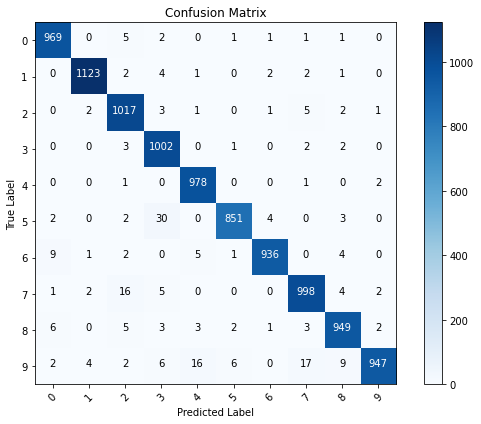

In [9]:
from sklearn.metrics import confusion_matrix
import itertools  # Add this import

with torch.no_grad():
    all_labels = []
    all_preds = []

    for inputs, labels in test_loader:
        # [SOMETHING IS MISSING HERE]
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot the confusion matrix as a heatmap
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    fmt = 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.show()

# List of class names for MNIST (digits 0-9)
class_names = [str(i) for i in range(10)]
    
plot_confusion_matrix(all_labels, all_preds, classes=class_names, title='Confusion Matrix')

**Exercise 6**: In the first cell of this script, we simply split the training set into a training and a validation set by randomly putting 20 per cent of the data aside. Why is this a "risky" strategy? What should we have ensured?